# [**Apprentissage extensible avec une approximation du noyau polynomial**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/6_7_kernel_approximation/plot_scalable_poly_kernels.ipynb)<br/>([_Scalable learning with polynomial kernel approximation_](https://scikit-learn.org/stable/auto_examples/kernel_approximation/plot_scalable_poly_kernels.html))

Cet exemple illustre l'utilisation de `PolynomialCountSketch` pour générer efficacement des approximations de l'espace des caractéristiques du noyau polynomial. Cela est utilisé pour entraîner des classifieurs linéaires qui approximent la précision des classifieurs noyautés.

Nous utilisons le jeu de données Covtype [2], en essayant de reproduire les expériences décrites dans l'article original de Tensor Sketch [1], c'est-à-dire l'algorithme implémenté par [**`PolynomialCountSketch`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html).

Tout d'abord, nous calculons la précision d'un classifieur linéaire sur les caractéristiques d'origine. Ensuite, nous entraînons des classifieurs linéaires sur différents nombres de caractéristiques (`n_components`) générées par [**`PolynomialCountSketch`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html), en approximant la précision d'un classifieur noyauté de manière extensible.

In [ ]:
# Auteur : Daniel Lopez-Sanchez <lope@usal.es>
# Licence : BSD 3 clause

# Préparation des données

Chargement du jeu de données Covtype, qui contient 581 012 échantillons de 54 caractéristiques chacun, répartis en 6 classes. L'objectif de ce jeu de données est de prédire le type de couverture forestière à partir de variables cartographiques uniquement (pas de données télédétectées). Après le chargement, nous le transformons en un problème de classification binaire afin de correspondre à la version du jeu de données du site web LIBSVM [2], utilisée dans [1].

In [1]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True)

y[y != 2] = 0
y[y == 2] = 1  # We will try to separate class 2 from the other 6 classes.

# Partitionnement des données

Nous sélectionnons ici 5 000 échantillons pour l'entraînement et 10 000 pour les tests. Pour reproduire réellement les résultats de l'article original de Tensor Sketch, sélectionnez 100 000 échantillons pour l'entraînement.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=5_000, test_size=10_000, random_state=42
)

# Normalisation des caractéristiques

Nous mettons maintenant à l'échelle les caractéristiques dans l'intervalle [0, 1] afin de correspondre au format du jeu de données sur le site web LIBSVM, puis nous les normalisons à une longueur unitaire, comme cela est fait dans l'article original de Tensor Sketch [1].

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer

mm = make_pipeline(MinMaxScaler(), Normalizer())
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

# Établissement d'un modèle de référence

Comme référence, nous entraînons un SVM linéaire sur les caractéristiques d'origine et affichons la précision. Nous mesurons également et stockons les précisions et les temps d'entraînement afin de les afficher ultérieurement.

In [7]:
%pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\franc\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\~klearn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.



                                              0.0/9.2 MB ? eta -:--:--
     -                                        0.3/9.2 MB 10.2 MB/s eta 0:00:01
     ---------                                2.1/9.2 MB 26.5 MB/s eta 0:00:01
     --------------------                     4.7/9.2 MB 37.2 MB/s eta 0:00:01
     --------------------------------         7.4/9.2 MB 43.1 MB/s eta 0:00:01
     ---------------------------------------  9.2/9.2 MB 45.2 MB/s eta 0:00:01
     ---------------------------------------- 9.2/9.2 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
import time
from sklearn.svm import LinearSVC

lsvm = LinearSVC(dual="auto")
start = time.time()
lsvm.fit(X_train, y_train)
lsvm_time = time.time() - start
lsvm_score = 100 * lsvm.score(X_test, y_test)

results = {"LSVM": {"time": lsvm_time, "score": lsvm_score}}
print(f"Linear SVM score on raw features: {lsvm_score:.2f}%")

Linear SVM score on raw features: 75.62%


## Établissement du modèle d'approximation du noyau

Ensuite, nous entraînons des SVM linéaires sur les caractéristiques générées par [**`PolynomialCountSketch`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html) avec différentes valeurs de `n_components`, démontrant ainsi que ces approximations de caractéristiques noyautées améliorent la précision de la classification linéaire. Dans des scénarios d'application typiques, `n_components` devrait être supérieur au nombre de caractéristiques dans la représentation d'entrée afin d'obtenir une amélioration par rapport à la classification linéaire. À titre indicatif, l'optimum entre le score d'évaluation et le coût de temps d'exécution est généralement atteint autour de `n_components = 10 * n_features`, bien que cela puisse dépendre du jeu de données spécifique. Notez que, puisque les échantillons d'origine ont 54 caractéristiques, la correspondance de caractéristiques explicite du noyau polynomial de degré quatre aurait approximativement 8,5 millions de caractéristiques (précisément, 54^4). Grâce à [**`PolynomialCountSketch`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html), nous pouvons condenser la majeure partie de l'information discriminante de cet espace de caractéristiques dans une représentation beaucoup plus compacte. Bien que nous exécutions l'expérience une seule fois (`n_runs = 1`) dans cet exemple, en pratique, il convient de répéter l'expérience plusieurs fois pour compenser la nature stochastique de [**`PolynomialCountSketch`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html).

In [5]:
from sklearn.kernel_approximation import PolynomialCountSketch

n_runs = 1
N_COMPONENTS = [250, 500, 1000, 2000]

for n_components in N_COMPONENTS:
    ps_lsvm_time = 0
    ps_lsvm_score = 0
    for _ in range(n_runs):
        pipeline = make_pipeline(
            PolynomialCountSketch(n_components=n_components, degree=4),
            LinearSVC(dual="auto"),
        )

        start = time.time()
        pipeline.fit(X_train, y_train)
        ps_lsvm_time += time.time() - start
        ps_lsvm_score += 100 * pipeline.score(X_test, y_test)

    ps_lsvm_time /= n_runs
    ps_lsvm_score /= n_runs

    results[f"LSVM + PS({n_components})"] = {
        "time": ps_lsvm_time,
        "score": ps_lsvm_score,
    }
    print(
        f"Linear SVM score on {n_components} PolynomialCountSketch "
        + f"features: {ps_lsvm_score:.2f}%"
    )

Linear SVM score on 250 PolynomialCountSketch features: 77.07%
Linear SVM score on 500 PolynomialCountSketch features: 77.95%
Linear SVM score on 1000 PolynomialCountSketch features: 78.32%
Linear SVM score on 2000 PolynomialCountSketch features: 78.00%


# Établissement du modèle SVM noyauté

Entraînez un SVM noyauté pour voir dans quelle mesure [**`PolynomialCountSketch`**](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.PolynomialCountSketch.html) approxime les performances du noyau. Cela peut prendre un certain temps, car la classe SVC n'a pas une très bonne extensibilité. C'est la raison pour laquelle les approximations de noyau sont si utiles :

In [6]:
from sklearn.svm import SVC

ksvm = SVC(C=500.0, kernel="poly", degree=4, coef0=0, gamma=1.0)

start = time.time()
ksvm.fit(X_train, y_train)
ksvm_time = time.time() - start
ksvm_score = 100 * ksvm.score(X_test, y_test)

results["KSVM"] = {"time": ksvm_time, "score": ksvm_score}
print(f"Kernel-SVM score on raw features: {ksvm_score:.2f}%")

Kernel-SVM score on raw features: 79.78%


# Comparaison des résultats

Enfin, tracez les résultats des différentes méthodes en fonction de leurs temps d'entraînement. Comme nous pouvons le voir, le SVM noyauté atteint une précision plus élevée, mais son temps d'entraînement est beaucoup plus long et, surtout, il augmentera beaucoup plus rapidement si le nombre d'échantillons d'entraînement augmente.

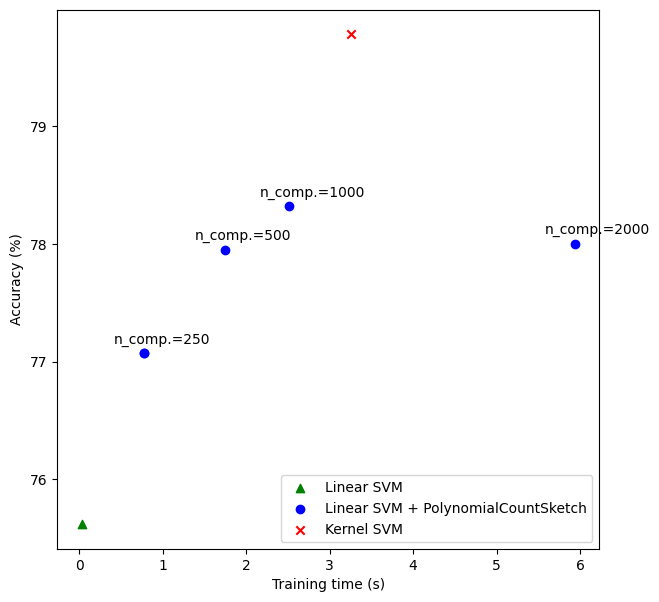

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    [
        results["LSVM"]["time"],
    ],
    [
        results["LSVM"]["score"],
    ],
    label="Linear SVM",
    c="green",
    marker="^",
)

ax.scatter(
    [
        results["LSVM + PS(250)"]["time"],
    ],
    [
        results["LSVM + PS(250)"]["score"],
    ],
    label="Linear SVM + PolynomialCountSketch",
    c="blue",
)

for n_components in N_COMPONENTS:
    ax.scatter(
        [
            results[f"LSVM + PS({n_components})"]["time"],
        ],
        [
            results[f"LSVM + PS({n_components})"]["score"],
        ],
        c="blue",
    )
    ax.annotate(
        f"n_comp.={n_components}",
        (
            results[f"LSVM + PS({n_components})"]["time"],
            results[f"LSVM + PS({n_components})"]["score"],
        ),
        xytext=(-30, 10),
        textcoords="offset pixels",
    )

ax.scatter(
    [
        results["KSVM"]["time"],
    ],
    [
        results["KSVM"]["score"],
    ],
    label="Kernel SVM",
    c="red",
    marker="x",
)

ax.set_xlabel("Training time (s)")
ax.set_ylabel("Accuracy (%)")
ax.legend()
plt.show()